# **Agents and Tools with LangGraph**

### Dr. Santosh Chapaneri
### Lead AI Product Engineer, Wolters Kluwer


In [ ]:
!pip install langgraph==0.3.2 mistralai pandas langchain==0.2.5

In [1]:
import os

os.environ["MISTRAL_API_KEY"] = "T5DdItPzE5WqcQrrOL7RLlpvJHQWoGHY"
api_key = os.environ["MISTRAL_API_KEY"]

In [2]:
import json
import pandas as pd
from mistralai import Mistral
import functools
from langgraph.graph import StateGraph, END

In [3]:
# === DATA ===
data = {
    'transaction_id': ['T1001', 'T1002', 'T1003', 'T1004', 'T1005'],
    'customer_id': ['C001', 'C002', 'C003', 'C002', 'C001'],
    'payment_amount': [125.50, 89.99, 120.00, 54.30, 210.20],
    'payment_date': ['2021-10-05', '2021-10-06', '2021-10-07', '2021-10-05', '2021-10-08'],
    'payment_status': ['Paid', 'Unpaid', 'Paid', 'Paid', 'Pending']
}

df = pd.DataFrame(data)
df

,transaction_id,customer_id,payment_amount,payment_date,payment_status
0,T1001,C001,125.50,2021-10-05,Paid
1,T1002,C002,89.99,2021-10-06,Unpaid
2,T1003,C003,120.00,2021-10-07,Paid
3,T1004,C002,54.30,2021-10-05,Paid
4,T1005,C001,210.20,2021-10-08,Pending


In [4]:
# === TOOL FUNCTIONS ===
def retrieve_payment_status(df: pd.DataFrame, transaction_id: str) -> str:
    if transaction_id in df['transaction_id'].values:
        status = df.loc[df['transaction_id'] == transaction_id, 'payment_status'].values[0]
        return f"The payment status for transaction {transaction_id} is: {status}"
    else:
        return f"Transaction ID {transaction_id} not found."

def retrieve_payment_date(df: pd.DataFrame, transaction_id: str) -> str:
    if transaction_id in df['transaction_id'].values:
        date = df.loc[df['transaction_id'] == transaction_id, 'payment_date'].values[0]
        return f"The payment date for transaction {transaction_id} is: {date}"
    else:
        return f"Transaction ID {transaction_id} not found."

names_to_functions = {
    "retrieve_payment_status": functools.partial(retrieve_payment_status, df=df),
    "retrieve_payment_date": functools.partial(retrieve_payment_date, df=df)
}

In [5]:
# === TOOL SPECIFICATIONS ===
tools = [
    {
        "type": "function",
        "function": {
            "name": "retrieve_payment_status",
            "description": "Retrieve the payment status for a given transaction ID.",
            "parameters": {
                "type": "object",
                "properties": {
                    "transaction_id": {"type": "string", "description": "The ID of the transaction"}
                },
                "required": ["transaction_id"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "retrieve_payment_date",
            "description": "Retrieve the payment date for a given transaction ID.",
            "parameters": {
                "type": "object",
                "properties": {
                    "transaction_id": {"type": "string", "description": "The ID of the transaction"}
                },
                "required": ["transaction_id"],
            },
        },
    }
]

In [6]:
# === MISTRAL CLIENT ===
model = "mistral-small-2506"

client = Mistral(api_key=api_key)

In [7]:
# === GRAPH STATE ===
State = dict

In [8]:
# === NODES ===

def planner(state: State) -> State:
    messages = state.get("messages", [])
    response = client.chat.complete(model=model, messages=messages, tools=tools, tool_choice="any")
    state["messages"].append(response.choices[0].message)
    state["tool_calls"] = response.choices[0].message.tool_calls
    return state

def execute_tools(state: State) -> State:
    "Executes the tools called by the model and adds the results to the state."
    tool_calls = state.get("tool_calls", [])
    messages = state.get("messages", [])
    tool_results = []

    for tool_call in tool_calls:
        function_name = tool_call.function.name
        function_parameters = json.loads(tool_call.function.arguments)

        if function_name in names_to_functions:
            function_result = names_to_functions[function_name](**function_parameters)
            tool_results.append(
                {
                "role":"tool",
                "name": function_name,
                "content": function_result,
                "tool_call": tool_call, 
            })
        else:
            tool_results.append({
                "role":"tool",
                "name": function_name,
                "content": json.dumps({"error": f"Function {function_name} not found."}),
                "tool_call_id": tool_call.id,
            })
    
    messages.extend(tool_results)
    state["messages"] = messages
    state["tool_calls"] = None
    return state

def final_response(state: State) -> State:
    response = client.chat.complete(model=model, messages=state["messages"])
    state["messages"].append(response.choices[0].message)
    return state

def check_tool_needed(state: State) -> str:
    return "call_tools" if state.get("tool_calls") else "final_answer"

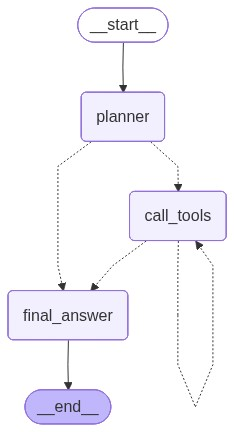

In [9]:
# === GRAPH ===
graph_builder = StateGraph(State)
graph_builder.set_entry_point("planner")

graph_builder.add_node("planner", planner)
graph_builder.add_node("call_tools", execute_tools)
graph_builder.add_node("final_answer", final_response)

graph_builder.add_conditional_edges("planner", check_tool_needed, {
    "call_tools": "call_tools",
    "final_answer": "final_answer"
})

graph_builder.add_conditional_edges("call_tools", check_tool_needed, {
    "call_tools": "call_tools",
    "final_answer": "final_answer"
})

graph_builder.add_edge("final_answer", END)

graph= graph_builder.compile()
graph

In [10]:
# === RUN Query ===
def run_query(user_query: str, with_system: bool = True):
    messages = []
    if with_system:
        messages.append(
            {
                "role": "system",
                "content": "You are a helpful assistant that provides information \
                about payment transactions."
            }
        )
    messages.append(
        {
            "role": "user",
            "content": user_query
        }
    )

    state = {"messages": messages}
    result = graph.invoke(state)

    return result["messages"][-1].content

In [11]:
user_query = "What's the status of my transaction T1001?"
# user_query = "When was transaction T1005 made?"
# user_query = "who is prime minister of india"

print(run_query(user_query))

SDKError: API error occurred: Status 400. Body: {"object":"error","message":"Tool call id has to be defined.","type":"invalid_request_invalid_args","param":null,"code":"3051"}